# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [26]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
from pyentrp import entropy as ent

## Load ELAsTiCC data set

In [6]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [7]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

## Loop through and compute the entropies

In [117]:
def get_ts_segments(flux, time, segment_length):

    ts_segments = []
    flux_segments = []

    current_segment_start = time[0]
    current_flux_segment = []
    current_time_segment = []

    for t, f in zip(time, flux):


        if t - current_segment_start <= segment_length:

            current_time_segment.append(t)
            current_flux_segment.append(f)            

        else:

            ts_segments.append(current_time_segment)
            flux_segments.append(current_flux_segment)

            current_segment_start = t
            current_time_segment = [t]
            current_flux_segment = [f]
            
    return ts_segments, flux_segments
    
def multiscale_entropy(flux, time, m, time_scales, tolerance=None):

    multiscale_entropies = []
    
    # Loop over all scales
    for scale in time_scales:

        # Get the non overlapping segments
        ts_segments, flux_segments = get_ts_segments(flux, time, scale)

        segment_entropies = []

        # Calculate the sample entropies for each non overlapping segment
        for segment in ts_segments:
            segment_entropy = ent.sample_entropy(segment, m)
            segment_entropies.append(segment_entropy)

        
        multiscale_entropies.append(np.mean(segment_entropies))
        
    return multiscale_entropies

In [193]:
filtered_classes = []
filtered_entropies = []

for i in range(len(astrophysical_classes)):

    # Find the detections
    phot_flag = X_ts[i]['detection_flag']
    idx = np.where(phot_flag==1)[0]

    # Find the time series and rescale
    time = X_ts[i]['scaled_time_since_first_obs'].to_numpy()[idx] * 100
    flux = X_ts[i]['scaled_FLUXCAL'].to_numpy()[idx] * 1000

    # Time scale in days
    time_scales = [50, 100, 150, 200, 250, 300]

    # Length of longest template vector considered for sample entropy
    m = 1

    if np.all(flux>0) and len(idx) >= 100:

        multiscale_entropies = multiscale_entropy(flux, time, 1, time_scales)

        filtered_classes.append(astrophysical_classes[i])
        filtered_entropies.append(multiscale_entropies)

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/pyentrp/entropy.py:194: RuntimeWarning: invalid value encountered in divide
  sampen = -np.log(N_temp[1:] / N_temp[:-1])


In [194]:
filtered_entropies = np.array(filtered_entropies)
filtered_classes = np.array(filtered_classes)

In [195]:
inf_idx = np.where(filtered_entropies==np.inf)[0]
filtered_entropies = np.delete(filtered_entropies, inf_idx, axis=0)
filtered_classes = np.delete(filtered_classes, inf_idx, axis=0)

In [196]:
nan_idx = np.where(np.isnan(filtered_entropies))[0]
filtered_entropies = np.delete(filtered_entropies, nan_idx, axis=0)
filtered_classes = np.delete(filtered_classes, nan_idx, axis=0)

In [197]:
filtered_entropies.shape

(3712, 6)

In [198]:
reducer = UMAP(random_state=42)
embedding = reducer.fit_transform(filtered_entropies)
embedding.shape

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(3712, 2)

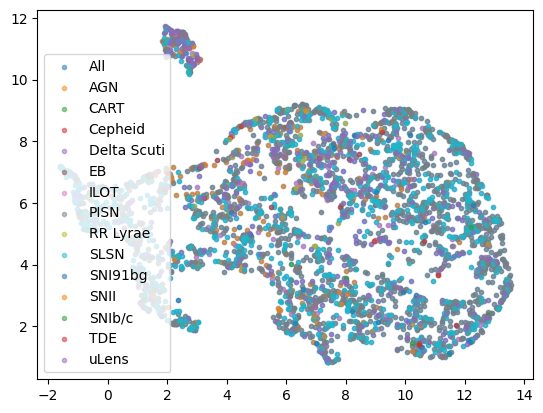

In [199]:
plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', alpha=0.5)
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', alpha=0.5)
plt.legend()
plt.show()

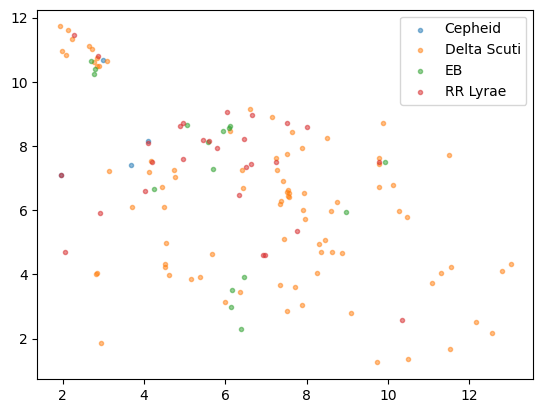

In [200]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', alpha=0.5)

plt.legend()

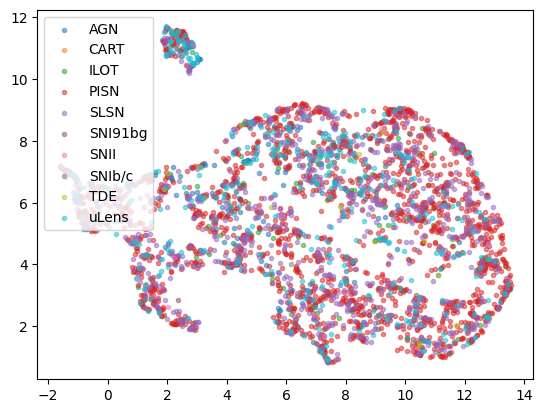

In [201]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c not in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', alpha=0.5)

plt.legend()

In [ ]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    